Eric's attempt

In [1]:
# Imports
import icepyx as ipx
import s3fs
import h5py
import numpy as np

**Cloud Accessed ATL03 data from icepyx docs**

In [2]:
# bounding box
# "producerGranuleId": "ATL03_20191130221008_09930503_004_01.h5",
short_name = 'ATL03'
spatial_extent = [-45, 58, -35, 75]
date_range = ['2019-11-30','2019-11-30']
reg=ipx.Query(short_name, spatial_extent, date_range)

In [3]:
gran_ids = reg.avail_granules(ids=True, s3urls=True)
gran_ids

C:\Users\zfair\Anaconda3\lib\site-packages\icepyx\core\granules.py:135: UserWarning: You MUST be pre-authenticated by NSIDC as a beta tester to have cloud access to ICESat-2 data
  warnings.warn(


[['ATL03_20191130112041_09860505_005_01.h5',
  'ATL03_20191130112606_09860506_005_01.h5',
  'ATL03_20191130220138_09930502_005_01.h5',
  'ATL03_20191130221008_09930503_005_01.h5'],
 ['s3://nsidc-cumulus-prod-protected/ATLAS/ATL03/005/2019/11/30/ATL03_20191130112041_09860505_005_01.h5',
  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/005/2019/11/30/ATL03_20191130112606_09860506_005_01.h5',
  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/005/2019/11/30/ATL03_20191130220138_09930502_005_01.h5',
  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/005/2019/11/30/ATL03_20191130221008_09930503_005_01.h5']]

In [5]:
reg.earthdata_login("icepyx_dev","icepyx_dev@gmail.com", s3token=True)

AssertionError: You must be working from a valid AWS instance to use s3 data access

In [5]:
credentials = reg._s3login_credentials

In [6]:
s3 = s3fs.S3FileSystem(key=credentials['accessKeyId'],
                       secret=credentials['secretAccessKey'],
                       token=credentials['sessionToken'])

In [7]:
s3url = gran_ids[1][0]

In [8]:
%time f = h5py.File(s3.open(s3url,'rb'),'r')

CPU times: user 59 ms, sys: 27.3 ms, total: 86.3 ms
Wall time: 251 ms


/srv/conda/envs/notebook/lib/python3.9/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x7f11e86a3d00>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


In [25]:
import h5py


def descend_obj(obj, sep='\t'):
    """
    Iterate through groups within a HDF5 file, and print
    the group/data set names/attributes

    Parameters
    ----------
    obj : h5py file object
        File object that represents the HDF5 file of interest.
        Used to read the file data.
    sep : whitespace character, optional
        Defines the kind of whitespace that separates print output. 
        The default is '\t', or tabbed whitespace.

    Returns
    -------
    None.

    """
    
    if type(obj) in [h5py._hl.group.Group, h5py._hl.files.File]:
        for key in obj.keys():
            print(sep, '-', key, ':', obj[key])
            descend_obj(obj[key], sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print(sep+'\t', '-', key, ':', obj.attrs[key])
            
            
def h5dump(path, group='/'):
    """
    Prints HDF5 file metadata, using the function above.

    Parameters
    ----------
    path : str
        String that provides the path to the desired file.
    group : str, optional
        Specifies the group from which to start. 
        The default is '/', or from the root group.

    Returns
    -------
    None.

    """
    
    with h5py.File(path, 'r') as f:
        descend_obj(f[group])

In [27]:
# Print structure of ATL03 data file. There is a lot here, but it may be useful if you don't know where variables are.
f = 'insert_h5_filename_here'

h5dump(f)

	 - METADATA : <HDF5 group "/METADATA" (9 members)>
		 - AcquisitionInformation : <HDF5 group "/METADATA/AcquisitionInformation" (4 members)>
			 - lidar : <HDF5 group "/METADATA/AcquisitionInformation/lidar" (0 members)>
			 - lidarDocument : <HDF5 group "/METADATA/AcquisitionInformation/lidarDocument" (0 members)>
			 - platform : <HDF5 group "/METADATA/AcquisitionInformation/platform" (0 members)>
			 - platformDocument : <HDF5 group "/METADATA/AcquisitionInformation/platformDocument" (0 members)>
		 - DataQuality : <HDF5 group "/METADATA/DataQuality" (2 members)>
			 - CompletenessOmission : <HDF5 group "/METADATA/DataQuality/CompletenessOmission" (0 members)>
			 - DomainConsistency : <HDF5 group "/METADATA/DataQuality/DomainConsistency" (0 members)>
		 - DatasetIdentification : <HDF5 group "/METADATA/DatasetIdentification" (0 members)>
		 - Extent : <HDF5 group "/METADATA/Extent" (0 members)>
		 - Lineage : <HDF5 group "/METADATA/Lineage" (24 members)>
			 - ANC01 : <HDF5 group "

					 - description : b'The estimate of uncorrelated height error. This is a six-valued array mapped onto gt1l, gt1r, gt2l, gt2r, gt3l, gt3r using the sc_orient parameter.'
					 - long_name : b'Uncorrelated Error'
					 - source : b'ATL03 ATBD, Section 7.7.2'
					 - units : b'meters'
			 - receiver : <HDF5 group "/ancillary_data/atlas_engineering/receiver" (2 members)>
				 - rx_bckgrd_sensitivity : <HDF5 dataset "rx_bckgrd_sensitivity": shape (6, 4), type "<f4">
						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
						 - contentType : b'auxiliaryInformation'
						 - description : b'Per-beam receiver background sensitivity. This is a six-valued array mapped onto gt1l, gt1r, gt2l, gt2r, gt3l, gt3r using the sc_orient parameter.'
						 - long_name : b'Receiver background sensivitiy'
						 - source : b'ATL02 ATBD, Sections 5.3.2'
						 - units : b'events/joule'
				 - rx_return_sensitivity : <HDF5 dataset "rx_re

							 - source : b'CAL42'
							 - units : b'seconds'
					 - sigma : <HDF5 dataset "sigma": shape (20,), type "<f8">
							 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
							 - contentType : b'auxiliaryInformation'
							 - description : b'Sigma (per ATLAS PCE channel; 1-16=strong, 17-20=weak)'
							 - long_name : b'Sigma'
							 - source : b'CAL42'
							 - units : b'seconds'
				 - side : <HDF5 dataset "side": shape (1,), type "<i4">
						 - contentType : b'auxiliaryInformation'
						 - description : b'A or B side of the detector bank'
						 - flag_meanings : b'A B'
						 - flag_values : [1 2]
						 - long_name : b'Detector Bank Side'
						 - source : b'CAL42'
						 - units : b'1'
						 - valid_max : 2
						 - valid_min : 1
				 - temperature : <HDF5 dataset "temperature": shape (1,), type "<f4">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Temperature for which calibrations are provided.'
						 - long_name : b'T

							 - contentType : b'auxiliaryInformation'
							 - description : b'Spot strength in events/shot (strength, deadtime)'
							 - long_name : b'Beam Strength'
							 - source : b'CAL19'
							 - units : b'1'
					 - width : <HDF5 dataset "width": shape (6, 498), type "<f8">
							 - contentType : b'auxiliaryInformation'
							 - description : b'Apparent width (width, deadtime)'
							 - long_name : b'Apparent Width'
							 - source : b'CAL19'
							 - units : b'ns'
				 - gt2r : <HDF5 group "/ancillary_data/calibrations/first_photon_bias/gt2r" (4 members)>
					 - dead_time : <HDF5 dataset "dead_time": shape (6,), type "<f4">
							 - contentType : b'auxiliaryInformation'
							 - description : b'Dead time value'
							 - long_name : b'Dead Time'
							 - source : b'CAL19'
							 - units : b'ns'
					 - ffb_corr : <HDF5 dataset "ffb_corr": shape (6, 160, 498), type "<f8">
							 - contentType : b'auxiliaryInformation'
							 - description : b'First Photon Bias Correc

					 - hist : <HDF5 dataset "hist": shape (20, 2000), type "<f8">
							 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
							 - contentType : b'auxiliaryInformation'
							 - description : b'Per-Channel Histogram'
							 - long_name : b'Histogram'
							 - source : b'CAL20'
							 - units : b'1'
					 - total_events : <HDF5 dataset "total_events": shape (20,), type "<i8">
							 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
							 - contentType : b'auxiliaryInformation'
							 - description : b'Number of events used in constructing the per-channel histogram'
							 - long_name : b'Total Events'
							 - source : b'CAL20'
							 - units : b'1'
				 - hist_x : <HDF5 dataset "hist_x": shape (2000,), type "<f8">
						 - CLASS : b'DIMENSION_SCALE'
						 - NAME : b'hist_x'
						 - REFERENCE_LIST : [(<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) 

				 - long_name : b'End UTC Time of Granule (CCSDS-A, Requested)'
				 - source : b'Derived'
				 - units : b'1'
		 - granule_start_utc : <HDF5 dataset "granule_start_utc": shape (1,), type "|S27">
				 - contentType : b'auxiliaryInformation'
				 - description : b'Requested start time (in UTC CCSDS-A) of this granule.'
				 - long_name : b'Start UTC Time of Granule (CCSDS-A, Requested)'
				 - source : b'Derived'
				 - units : b'1'
		 - gt1l : <HDF5 group "/ancillary_data/gt1l" (1 members)>
			 - signal_find_input : <HDF5 group "/ancillary_data/gt1l/signal_find_input" (32 members)>
				 - addpad_flag : <HDF5 dataset "addpad_flag": shape (5,), type "<i4">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Binary (logical) that if true (=1) then identify additional photon events as padding to achieve htspanin for each time interval sig_find_t_inc.'
						 - long_name : b'Additional photon flag'
						 - source : b'ATL03, Section 5, Addpad'
						 - units : b'1'
		

				 - r2 : <HDF5 dataset "r2": shape (5,), type "<f8">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Minimum ratio of (maximum number of photons in any one bin of contiguous signal bins)/(Maximum number of photons in largest bin) in order to accept a group of potential signal bins as signal.  Surface-type dependent.'
						 - long_name : b'Minimum ratio2'
						 - source : b'ATL03, Section 5, R2'
						 - units : b'1'
				 - sig_find_t_inc : <HDF5 dataset "sig_find_t_inc": shape (5,), type "<f8">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Time increment the algorithm uses to step through the photon cloud in a granule. Histograms are formed at each sig_find_t_inc interval to identify signal photon events.'
						 - long_name : b'Histogram time increment'
						 - source : b'ATL03, Section 5, _time'
						 - units : b'seconds'
				 - snrlow : <HDF5 dataset "snrlow": shape (5,), type "<f8">
						 - contentType : b'auxiliaryInformati

				 - n_delta_z1 : <HDF5 dataset "n_delta_z1": shape (5,), type "<i4">
						 - contentType : b'auxiliaryInformation'
						 - description : b'The number of increments between delta_zmin and delat_zmax1.  Surface-type dependent.'
						 - long_name : b'number of increments in z1'
						 - source : b'ATL03, Section 5, n_z1'
						 - units : b'counts'
				 - n_delta_z2 : <HDF5 dataset "n_delta_z2": shape (5,), type "<i4">
						 - contentType : b'auxiliaryInformation'
						 - description : b'The number of increments between delta_zmax1 and delta_zmax2.  Surface-type dependent.'
						 - long_name : b'number of increments in z2'
						 - source : b'ATL03, Section 5, n_z2'
						 - units : b'counts'
				 - nbin_min : <HDF5 dataset "nbin_min": shape (5,), type "<i4">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Minimum number of bins in a histogram required for the algorithm to be able to process the histogram.'
						 - long_name : b'Minimum number of bins'
			

						 - units : b'1'
				 - htspanmin : <HDF5 dataset "htspanmin": shape (5,), type "<f8">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Minimum height span for each time interval of photons with confidence flag > 0.  If the height span is < htspanmin then all photons not previously selected within +/- htspanmin/2 of the median height of the signal photons selected are marked with a confidence flag of 1.  Surface-type dependent.'
						 - long_name : b'Minimum height span'
						 - source : b'ATL03, Section 5, Htspanmin'
						 - units : b'meters'
				 - lslant_flag : <HDF5 dataset "lslant_flag": shape (5,), type "<i4">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Binary (logical) flag, if true (=1) then perform slant histogramming for the strong beam.  Surface-type dependent.'
						 - flag_meanings : b'false true'
						 - flag_values : [0 1]
						 - long_name : b'Flag to request slant histogramming for strong beams.'
						 - so

						 - units : b'1'
				 - htspanmin : <HDF5 dataset "htspanmin": shape (5,), type "<f8">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Minimum height span for each time interval of photons with confidence flag > 0.  If the height span is < htspanmin then all photons not previously selected within +/- htspanmin/2 of the median height of the signal photons selected are marked with a confidence flag of 1.  Surface-type dependent.'
						 - long_name : b'Minimum height span'
						 - source : b'ATL03, Section 5, Htspanmin'
						 - units : b'meters'
				 - lslant_flag : <HDF5 dataset "lslant_flag": shape (5,), type "<i4">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Binary (logical) flag, if true (=1) then perform slant histogramming for the strong beam.  Surface-type dependent.'
						 - flag_meanings : b'false true'
						 - flag_values : [0 1]
						 - long_name : b'Flag to request slant histogramming for strong beams.'
						 - so

						 - contentType : b'auxiliaryInformation'
						 - description : b'Multiplier of standard deviation of linear fit to signal photons used to edit out noise during running linear fit edit of outliers.'
						 - long_name : b'Multiplier of STD of linear fit'
						 - source : b'ATL03, Section 5, e_linfit_edit'
						 - units : b'1'
				 - e_linfit_slant : <HDF5 dataset "e_linfit_slant": shape (5,), type "<f8">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Multiplier of sigma_linfit, the standard deviation of the residuals between the actual photon events used to estimate the surface using a linear fit; all photons with height > e_linfit_slant'
						 - long_name : b'Multiplier of sigma linfit'
						 - source : b'ATL03, Section 5, e_linfit_slant'
						 - units : b'1'
				 - e_m : <HDF5 dataset "e_m": shape (5,), type "<f8">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Multiplier of standard deviation of the number of background ph

						 - contentType : b'auxiliaryInformation'
						 - description : b'Binary (logical) that if true (=1) then identify additional photon events as padding to achieve htspanin for each time interval sig_find_t_inc.'
						 - long_name : b'Additional photon flag'
						 - source : b'ATL03, Section 5, Addpad'
						 - units : b'1'
				 - alpha_inc : <HDF5 dataset "alpha_inc": shape (5,), type "<f8">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Increment by which the slope is varied for slant histogramming over large gaps'
						 - long_name : b'Slope Increment'
						 - source : b'ATL03, Section 5, _inc'
						 - units : b'radians'
				 - alpha_max : <HDF5 dataset "alpha_max": shape (5,), type "<f8">
						 - contentType : b'auxiliaryInformation'
						 - description : b'Maximum slope allowed for slant histogram; if larger than this then don'
						 - long_name : b'Maximum Slope'
						 - source : b'ATL03, Section 5, _max'
						 - units : b'radians'
				 - de

				 - contentType : b'auxiliaryInformation'
				 - description : b'The starting cycle number associated with the data contained within this granule. The cycle number is the counter of the number of 91-day repeat cycles completed by the mission.'
				 - long_name : b'Starting Cycle'
				 - source : b'Derived'
				 - units : b'1'
				 - valid_max : 99
				 - valid_min : 0
		 - start_delta_time : <HDF5 dataset "start_delta_time": shape (1,), type "<f8">
				 - CLASS : b'DIMENSION_SCALE'
				 - REFERENCE_LIST : [(<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0)]
				 - contentType : b'auxiliaryInformation'
				 - description : b'Number of GPS seconds since the ATLAS SDP epoch at the first data point in the file. The ATLAS Standard Data Products (SDP) epoch offset is defined within /ancillary_data/atlas_sdp_gps_epoch as the number of GP

					 - units : b'1'
					 - valid_max : 1
					 - valid_min : 0
			 - tep_sec_window : <HDF5 dataset "tep_sec_window": shape (2,), type "<f4">
					 - contentType : b'auxiliaryInformation'
					 - description : b'The range of the secondary TEP window. Bins within this range are used in computing TEP rate.'
					 - long_name : b'TEP Secondary Window'
					 - source : b'Derived'
					 - units : b'seconds'
			 - tep_start_x : <HDF5 dataset "tep_start_x": shape (1,), type "<f4">
					 - contentType : b'auxiliaryInformation'
					 - description : b'Value at the left edge of the first histogram bin.'
					 - long_name : b'TEP Start X'
					 - source : b'Derived'
					 - units : b'seconds'
			 - tep_valid_spot : <HDF5 dataset "tep_valid_spot": shape (6,), type "|i1">
					 - contentType : b'referenceInformation'
					 - description : b'A 6x1 array indicating which TEP to use for each spot that does not have a TEP associated with it (e.g. which TEP to use to characterize spots 2, 4, 5, and 6)

			 - CLASS : b'DIMENSION_SCALE'
			 - NAME : b'/ds_surf_type'
			 - REFERENCE_LIST : [(<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1) (<HDF5 object reference>, 1)
 (<HDF5 object reference>, 1)

					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time'
					 - description : b'The ellipsoidal heights with respect to WGS-84 of the top of the telemetry band 1, with all geophysical corrections applied.'
					 - long_name : b'Ellipsoidal height of the top of the telemetry band 1.'
					 - source : b'ATL03 ATBD, Section 3.2, 7.3.2'
					 - units : b'meters'
			 - tlm_top_band2 : <HDF5 dataset "tlm_top_band2": shape (65012,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time'
					 - description : b'The ellipsoidal heights with respect to WGS-84 of the top of the telemetry band 2, with all geophysical corrections applied.'
					 - long_name : b'Ellipsoidal height of the top of the telemetry band 2.'
					 - source : b'ATL03 ATBD, Section 3.2, 7.3.2'
					 - units : b'meter

					 - source : b'ANC04, ANC05'
					 - units : b'1'
					 - valid_max : 3
					 - valid_min : 0
			 - range_bias_corr : <HDF5 dataset "range_bias_corr": shape (9450,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'The range_bias estimated from geolocation analysis.'
					 - long_name : b'range bias correction'
					 - source : b'ATL03G ATBD, Section 3.6'
					 - units : b'meters'
			 - ref_azimuth : <HDF5 dataset "ref_azimuth": shape (9450,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Azimuth of the unit pointing vector for the reference photon in the local ENU

					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'qualityInformation'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Estimated geodetic east Longitude uncertainty (1-sigma), for the reference photon bounce point.'
					 - long_name : b'longitude uncertainty'
					 - source : b'ATL03G ATBD, Section 3.6'
					 - units : b'degrees'
			 - solar_azimuth : <HDF5 dataset "solar_azimuth": shape (9450,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'The azimuth of the sun position vector from the reference photon bounce point position in the local ENU frame.  The angle is measured from North and is positive towards East.  ATL03g provides this value 

					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time'
					 - description : b'Geoid height above WGS-84 reference ellipsoid (range -107 to 86m) in the tide-free system.  Not applied on the product; requested by higher-level products. (see geoid_free2mean to convert to the mean-tide system)'
					 - long_name : b'Geoid'
					 - source : b'ATL03 ATBD, Section 6.3.8'
					 - units : b'meters'
			 - geoid_free2mean : <HDF5 dataset "geoid_free2mean": shape (9450,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time'
					 - description : b'Additive value to convert geoid heights from the tide-free system to the mean-tide system. (Add to geoid to get the geoid heights in the mean-tide system.)'
					 - long_name : b'G

			 - ph_id_pulse : <HDF5 dataset "ph_id_pulse": shape (7320196,), type "|u1">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time lat_ph lon_ph'
					 - description : b'The laser pulse counter is part of photon ID and counts from 1 to 200 and is reset for each new major frame.'
					 - long_name : b'laser pulse counter'
					 - source : b'Derived as part of Photon ID'
					 - units : b'counts'
			 - quality_ph : <HDF5 dataset "quality_ph": shape (7320196,), type "|i1">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'qualityInformation'
					 - coordinates : b'delta_time lat_ph lon_ph'
					 - description : b'Indicates the quality of the associated photon. 0=nominal, 1=possible_afterpulse, 2=possible_impulse_response_effect, 3=possible_tep. Use this flag in conjunction with signal_conf_ph to identify those photons that are likely noise

						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The mean of the number of background counts expected in one height bin of the histogram of width dzATM over time period, dtATM'
						 - long_name : b'background counts per bin'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'counts'
				 - bckgrd_sigma : <HDF5 dataset "bckgrd_sigma": shape (47650,), type "<f4">
						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The standard deviation of the number of background counts expected in one height bin of the histogram of width dzATM over time period, dtATM'
						 - long_name : b'background counts per bin sigma'
						 - source : b'ATL03 ATBD, Sectio

					 - long_name : b'Height of the telemetry band 2'
					 - source : b'ATL03 ATBD, Section 7.3.2'
					 - units : b'meters'
			 - tlm_top_band1 : <HDF5 dataset "tlm_top_band1": shape (64966,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time'
					 - description : b'The ellipsoidal heights with respect to WGS-84 of the top of the telemetry band 1, with all geophysical corrections applied.'
					 - long_name : b'Ellipsoidal height of the top of the telemetry band 1.'
					 - source : b'ATL03 ATBD, Section 3.2, 7.3.2'
					 - units : b'meters'
			 - tlm_top_band2 : <HDF5 dataset "tlm_top_band2": shape (64966,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time'
					 - description : b'The ellipsoidal heights with respect to WGS-84 of the top of the teleme

					 - source : b'ATL03G ATBD'
					 - units : b'meters'
			 - sigma_along : <HDF5 dataset "sigma_along": shape (9472,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'qualityInformation'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Estimated cartesian along-track uncertainty (1-sigma) for the reference photon'
					 - long_name : b'along-track geolocation uncertainity'
					 - source : b'ATL03G ATBD'
					 - units : b'meters'
			 - sigma_h : <HDF5 dataset "sigma_h": shape (9472,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'qualityInformation'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Estimated height uncertainty (1-sigma) for the reference photon bounce point.'
					 - lon

		 - geophys_corr : <HDF5 group "/gt1r/geophys_corr" (13 members)>
			 - dac : <HDF5 dataset "dac": shape (9472,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time'
					 - description : b'Dynamic Atmospheric Correction (DAC) includes inverted barometer (IB) effect. This correction is not applied to the photon heights and provided only as supplemental information.'
					 - long_name : b'Dynamic Atmosphere Correction'
					 - source : b'ATL03 ATBD, Section 6.3.2'
					 - units : b'meters'
			 - delta_time : <HDF5 dataset "delta_time": shape (9472,), type "<f8">
					 - CLASS : b'DIMENSION_SCALE'
					 - NAME : b'delta_time'
					 - REFERENCE_LIST : [(<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object referenc

					 - description : b'Along-track distance in a segment projected to the ellipsoid of the received photon, based on the Along-Track Segment algorithm.  Total along track distance can be found by adding this value to the sum of segment lengths measured from the start of the most recent reference groundtrack.'
					 - long_name : b'Distance from equator crossing.'
					 - source : b'ATL03 ATBD, Section 3.1'
					 - units : b'meters'
			 - h_ph : <HDF5 dataset "h_ph": shape (5085355,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'physicalMeasurement'
					 - coordinates : b'delta_time lat_ph lon_ph'
					 - description : b'Height of each received photon, relative to the WGS-84 ellipsoid including the geophysical corrections noted in Section 6. Please note that neither the geoid, ocean tide nor the dynamic atmosphere (DAC) corrections are applied to the ellipsoidal heights.'
					 - long_name : b'Photon WGS84 Height'
					 

						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The histogram bin width (integration time) along-track used to find signal photons.'
						 - long_name : b'bin width size'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'seconds'
				 - z_pc_delta : <HDF5 dataset "z_pc_delta": shape (32039,), type "<f4">
						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'Height bin size of the histogram used to find signal photons.'
						 - long_name : b'bin height size'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'meters'
			 - land_ice : <HDF5 group "/gt1r/signal_find_output/land_ice" (5 members)>
				 - bckgrd_mean : <HDF5 dataset "bckgrd_mean": shape (74798,), type "<f4">
						 - DIMENSION_LIST : [array([<HDF5

					 - CLASS : b'DIMENSION_SCALE'
					 - NAME : b'delta_time'
					 - REFERENCE_LIST : [(<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>,

					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Spacecraft pitch, roll, and yaw angles, are computed using 3, 2, 1 Euler angle sequence, posted at the geolocation segment rate, and the units are degrees. Angles represent the deviation from a coordinate system whose z-axis is perpendicular to the reference ellipsoid of the Earth (pointing nadir), y-axis is perpendicular to the orbit plane, and x-axis completes the triad in the direction of spacecraft velocity. Note: yaw angle is near 0deg when ICESat-2 is flying forward (positive beta angle), near 180deg when ICESat-2 is flying backward (negative beta angle).'
					 - long_name : b'roll'
					 - source : b'ANC04'
					 - units : b'degrees'
			 - segment_dist_x : <HDF5 dataset "segment_dist_x": shape (10283,), type "<f8">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'modelResult'
					 - coordinat

					 - description : b'Elapsed seconds from the ATLAS SDP GPS Epoch, corresponding to the transmit time of the reference photon. The ATLAS Standard Data Products (SDP) epoch offset is defined within /ancillary_data/atlas_sdp_gps_epoch as the number of GPS seconds between the GPS epoch (1980-01-06T00:00:00.000000Z UTC) and the ATLAS SDP epoch. By adding the offset contained within atlas_sdp_gps_epoch to delta time parameters, the time in gps_seconds relative to the GPS epoch can be computed.'
					 - long_name : b'Elapsed GPS seconds'
					 - source : b'Operations'
					 - standard_name : b'time'
					 - units : b'seconds since 2018-01-01'
			 - dem_flag : <HDF5 dataset "dem_flag": shape (10283,), type "|i1">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 127
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time'
					 - description : b'Indicates source of the DEM height. Values: 0=None, 1=Arctic, 2=Global, 3=MS

					 - coordinates : b'delta_time lat_ph lon_ph'
					 - description : b'Channel number assigned for each received photon event. This is part of the photon ID. Values range from 1 to 120 to span all channels and rise/fall edges. Values 1 to 60 are for falling edge; PCE1 (1 to 20), PCE 2 (21 to 40) and PCE3 (41 to 60). Values 61 to 120 are for rising edge; PCE1 (61 to 80), PCE 2 (81 to 100) and PC3 (101 to 120).'
					 - long_name : b'Receive channel id'
					 - source : b'Derived as part of Photon ID'
					 - units : b'1'
					 - valid_max : 120
					 - valid_min : 1
			 - ph_id_count : <HDF5 dataset "ph_id_count": shape (5754302,), type "|i1">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time lat_ph lon_ph'
					 - description : b'The photon event counter is part of photon ID and counts from 1 for each channel until reset by laser pulse counter.'
					 - long_name : b'photon event

						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The standard deviation of the number of background counts expected in one height bin of the histogram of width dzATM over time period, dtATM'
						 - long_name : b'background counts per bin sigma'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'counts'
				 - delta_time : <HDF5 dataset "delta_time": shape (134553,), type "<f8">
						 - CLASS : b'DIMENSION_SCALE'
						 - NAME : b'delta_time'
						 - REFERENCE_LIST : [(<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)]
						 - contentType : b'referenceInformation'
						 - description : b'Number of GPS seconds since the ATLAS SDP epoch. The ATLAS Standard Data Products (SDP) epoch offset is defined within /ancillary_data/atlas_sdp_gps_epoch

					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time'
					 - description : b'The height of the altimetric range window.  This is the height over which the 50-shot sum is generated.  Parameter is ingested at 50-Hz, and values are repeated to form a 200-Hz array.'
					 - long_name : b'Altimetric range window width'
					 - source : b'ATL03 ATBD Section 7.3'
					 - units : b'meters'
			 - bckgrd_int_height_reduced : <HDF5 dataset "bckgrd_int_height_reduced": shape (65001,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time'
					 - description : b'The height of the altimetric range window after subtracting the height span of the signal photon events in the 50-shot span.'
					 - long_name : b'Altimetric range window height - reduced'
					 - source : b'ATL03 ATBD Section 7.3'
					 - unit

					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Reference height of the neutral atmosphere range correction'
					 - long_name : b'Neutral atmosphere ref height'
					 - source : b'ATL03a ATBD'
					 - units : b'meters'
			 - ph_index_beg : <HDF5 dataset "ph_index_beg": shape (10294,), type "<i8">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 0
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Index (1-based) within the photon-rate data of the first photon within this segment. Use in conjunction with segment_ph_cnt.'
					 - long_name : b'Photon Index Begin'
					 - source : b'Derived'
					 - units : b'counts'
			 - pitch : <HDF5 dataset "pitch

					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 0
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Number of photons in a given along-track segment. In the case of no photons within the segment (segment_ph_cnt=0), most other parameters are filled with invalid or best-estimate values. Maintaining geolocation segments with no photons allows for the geolocation segment arrays to be directly aligned across the gtx groups.'
					 - long_name : b'Number of photons'
					 - source : b'Derived'
					 - units : b'counts'
			 - sigma_across : <HDF5 dataset "sigma_across": shape (10294,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'qualityInformation'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Es

					 - source : b'ATL03 ATBD, Section 6.3.2'
					 - units : b'meters'
			 - delta_time : <HDF5 dataset "delta_time": shape (10294,), type "<f8">
					 - CLASS : b'DIMENSION_SCALE'
					 - NAME : b'delta_time'
					 - REFERENCE_LIST : [(<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)]
					 - contentType : b'referenceInformation'
					 - description : b'Elapsed seconds from the ATLAS SDP GPS Epoch, corresponding to the transmit time of the reference photon. The ATLAS Standard Data Products (SDP) epoch offset is defined within /ancillary_data/atlas_sdp_gps_epoch as the number of GPS seconds between the GPS epoch (1980-01-06T00:00:00.000000Z UTC) and the ATLAS SDP epoch. By adding the off

					 - valid_min : -90.0
			 - lon_ph : <HDF5 dataset "lon_ph": shape (5219784,), type "<f8">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time lat_ph'
					 - description : b'Longitude of each received photon. Computed from the ECF Cartesian coordinates of the bounce point.'
					 - long_name : b'Longitude'
					 - source : b'ATL03g ATBD, Section 3.4'
					 - standard_name : b'longitude'
					 - units : b'degrees_east'
					 - valid_max : 180.0
					 - valid_min : -180.0
			 - pce_mframe_cnt : <HDF5 dataset "pce_mframe_cnt": shape (5219784,), type "<u4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time lat_ph lon_ph'
					 - description : b'The major frame counter is read from the digital flow controller in a given PCE card.  The counter identifies individual major frames across diag a

				 - bckgrd_mean : <HDF5 dataset "bckgrd_mean": shape (74899,), type "<f4">
						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The mean of the number of background counts expected in one height bin of the histogram of width dzATM over time period, dtATM'
						 - long_name : b'background counts per bin'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'counts'
				 - bckgrd_sigma : <HDF5 dataset "bckgrd_sigma": shape (74899,), type "<f4">
						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The standard deviation of the number of background counts expected in one height bin of the histogram of width dzATM over time period, dtATM'
						 - long_na

						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The histogram bin width (integration time) along-track used to find signal photons.'
						 - long_name : b'bin width size'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'seconds'
				 - z_pc_delta : <HDF5 dataset "z_pc_delta": shape (47827,), type "<f4">
						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'Height bin size of the histogram used to find signal photons.'
						 - long_name : b'bin height size'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'meters'
	 - gt3l : <HDF5 group "/gt3l" (5 members)>
		 - bckgrd_atlas : <HDF5 group "/gt3l/bckgrd_atlas" (12 members)>
			 - bck

			 - neutat_delay_derivative : <HDF5 dataset "neutat_delay_derivative": shape (10290,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Change in neutral atmospheric delay per height change'
					 - long_name : b'(Neutral Atmosphere delay)/dh'
					 - source : b'ATL03a ATBD'
					 - units : b'meters/meters'
			 - neutat_delay_total : <HDF5 dataset "neutat_delay_total": shape (10290,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Total neutral atmosphere delay correction (wet+dry).'
					 - long_name : b'Total Neutral Atmospheric Delay'
					 - source : b'ATL03a ATBD

					 - units : b'meters'
			 - sigma_along : <HDF5 dataset "sigma_along": shape (10290,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'qualityInformation'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Estimated cartesian along-track uncertainty (1-sigma) for the reference photon'
					 - long_name : b'along-track geolocation uncertainity'
					 - source : b'ATL03G ATBD'
					 - units : b'meters'
			 - sigma_h : <HDF5 dataset "sigma_h": shape (10290,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'qualityInformation'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Estimated height uncertainty (1-sigma) for the reference photon bounce point.'
					 - long_name : b'height uncertainty'

					 - units : b'meters'
			 - tide_oc_pole : <HDF5 dataset "tide_oc_pole": shape (10290,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time'
					 - description : b'Surface deformation of the Earth due to loading from the centrifugal effect of polar motion upon the oceans (-2 to 2 mm).'
					 - long_name : b'Ocean Pole Tide'
					 - source : b'ATL03 ATBD, Section 6.3.6'
					 - units : b'meters'
			 - tide_ocean : <HDF5 dataset "tide_ocean": shape (10290,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'referenceInformation'
					 - coordinates : b'delta_time'
					 - description : b'Ocean Tides including diurnal and semi-diurnal (harmonic analysis), and longer period tides (dynamic and self-consistent equilibrium). This correction is no

					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'qualityInformation'
					 - coordinates : b'delta_time lat_ph lon_ph'
					 - description : b'Indicates the quality of the associated photon. 0=nominal, 1=possible_afterpulse, 2=possible_impulse_response_effect, 3=possible_tep. Use this flag in conjunction with signal_conf_ph to identify those photons that are likely noise or likely signal.'
					 - flag_meanings : b'nominal possible_afterpulse possible_impulse_response_effect possible_tep'
					 - flag_values : [0 1 2 3]
					 - long_name : b'Photon Quality'
					 - source : b'ATL03 ATBD'
					 - units : b'1'
					 - valid_max : 3
					 - valid_min : 0
			 - signal_conf_ph : <HDF5 dataset "signal_conf_ph": shape (5647651, 5), type "|i1">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'qualityInformation'
					 - coordinates : b'delta_time lat

						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The mean of the number of background counts expected in one height bin of the histogram of width dzATM over time period, dtATM'
						 - long_name : b'background counts per bin'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'counts'
				 - bckgrd_sigma : <HDF5 dataset "bckgrd_sigma": shape (134602,), type "<f4">
						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The standard deviation of the number of background counts expected in one height bin of the histogram of width dzATM over time period, dtATM'
						 - long_name : b'background counts per bin sigma'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'counts'
				 - delta_time : <HDF5 dataset "delta_t

					 - long_name : b'ATLAS 50-shot background count'
					 - source : b'ATL03 ATBD Section 7.3'
					 - units : b'counts'
			 - bckgrd_counts_reduced : <HDF5 dataset "bckgrd_counts_reduced": shape (64979,), type "<i4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time'
					 - description : b'Number of photon counts in the 50-shot sum after subtracting the number of signal photon events, defined as in ATBD Section 5, in that span.'
					 - long_name : b'ATLAS 50-shot background count - reduced'
					 - source : b'ATL03 ATBD Section 7.3'
					 - units : b'counts'
			 - bckgrd_hist_top : <HDF5 dataset "bckgrd_hist_top": shape (64979,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time'
					 - description : b'The height of the top of the altimetric histogram, in meters above the WGS-84 

					 - description : b'The fraction of pulses within the segment determined to be nearly saturated.'
					 - long_name : b'Near Saturation Fraction'
					 - source : b'ATL03 ATBD'
					 - units : b'1'
					 - valid_max : 1.0
					 - valid_min : 0.0
			 - neutat_delay_derivative : <HDF5 dataset "neutat_delay_derivative": shape (10290,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Change in neutral atmospheric delay per height change'
					 - long_name : b'(Neutral Atmosphere delay)/dh'
					 - source : b'ATL03a ATBD'
					 - units : b'meters/meters'
			 - neutat_delay_total : <HDF5 dataset "neutat_delay_total": shape (10290,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'mode

					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Spacecraft pitch, roll, and yaw angles, are computed using 3, 2, 1 Euler angle sequence, posted at the geolocation segment rate, and the units are degrees. Angles represent the deviation from a coordinate system whose z-axis is perpendicular to the reference ellipsoid of the Earth (pointing nadir), y-axis is perpendicular to the orbit plane, and x-axis completes the triad in the direction of spacecraft velocity. Note: yaw angle is near 0deg when ICESat-2 is flying forward (positive beta angle), near 180deg when ICESat-2 is flying backward (negative beta angle).'
					 - long_name : b'roll'
					 - source : b'ANC04'
					 - units : b'degrees'
			 - segment_dist_x : <HDF5 dataset "segment_dist_x": shape (10290,), type "<f8">
					 - DIMENSION_L

					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - _FillValue : 3.4028235e+38
					 - contentType : b'modelResult'
					 - coordinates : b'delta_time reference_photon_lat reference_photon_lon'
					 - description : b'Spacecraft pitch, roll, and yaw angles, are computed using 3, 2, 1 Euler angle sequence, posted at the geolocation segment rate, and the units are degrees. Angles represent the deviation from a coordinate system whose z-axis is perpendicular to the reference ellipsoid of the Earth (pointing nadir), y-axis is perpendicular to the orbit plane, and x-axis completes the triad in the direction of spacecraft velocity. Note: yaw angle is near 0deg when ICESat-2 is flying forward (positive beta angle), near 180deg when ICESat-2 is flying backward (negative beta angle).'
					 - long_name : b'Yaw'
					 - source : b'ANC04'
					 - units : b'degrees'
		 - geophys_corr : <HDF5 group "/gt3r/geophys_corr" (13 members)>
			 - dac : <HDF5 dataset "dac": sha

					 - coordinates : b'lat_ph lon_ph'
					 - description : b'The transmit time of a given photon, measured in seconds from the ATLAS Standard Data Product Epoch. Note that multiple received photons associated with a single transmit pulse will have the same delta_time. The ATLAS Standard Data Products (SDP) epoch offset is defined within /ancillary_data/atlas_sdp_gps_epoch as the number of GPS seconds between the GPS epoch (1980-01-06T00:00:00.000000Z UTC) and the ATLAS SDP epoch. By adding the offset contained within atlas_sdp_gps_epoch to delta time parameters, the time in gps_seconds relative to the GPS epoch can be computed.'
					 - long_name : b'Elapsed GPS seconds'
					 - source : b'Operations'
					 - standard_name : b'time'
					 - units : b'seconds since 2018-01-01'
			 - dist_ph_across : <HDF5 dataset "dist_ph_across": shape (4293495,), type "<f4">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'modelResult'
					 - coordin

						 - contentType : b'referenceInformation'
						 - description : b'Number of GPS seconds since the ATLAS SDP epoch. The ATLAS Standard Data Products (SDP) epoch offset is defined within /ancillary_data/atlas_sdp_gps_epoch as the number of GPS seconds between the GPS epoch (1980-01-06T00:00:00.000000Z UTC) and the ATLAS SDP epoch. By adding the offset contained within atlas_sdp_gps_epoch to delta time parameters, the time in gps_seconds relative to the GPS epoch can be computed.'
						 - long_name : b'Elapsed GPS seconds'
						 - source : b'Derived via Time Tagging'
						 - standard_name : b'time'
						 - units : b'seconds since 2018-01-01'
				 - t_pc_delta : <HDF5 dataset "t_pc_delta": shape (32057,), type "<f4">
						 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)]
						 - _FillValue : 3.4028235e+38
						 - contentType : b'qualityInformation'
						 - coordinates : b'delta_time'
						 - description : b'The histogram bin width (integration time) along-

						 - description : b'The standard deviation of the number of background counts expected in one height bin of the histogram of width dzATM over time period, dtATM'
						 - long_name : b'background counts per bin sigma'
						 - source : b'ATL03 ATBD, Section 5'
						 - units : b'counts'
				 - delta_time : <HDF5 dataset "delta_time": shape (47713,), type "<f8">
						 - CLASS : b'DIMENSION_SCALE'
						 - NAME : b'delta_time'
						 - REFERENCE_LIST : [(<HDF5 object reference>, 0) (<HDF5 object reference>, 0)
 (<HDF5 object reference>, 0) (<HDF5 object reference>, 0)]
						 - contentType : b'referenceInformation'
						 - description : b'Number of GPS seconds since the ATLAS SDP epoch. The ATLAS Standard Data Products (SDP) epoch offset is defined within /ancillary_data/atlas_sdp_gps_epoch as the number of GPS seconds between the GPS epoch (1980-01-06T00:00:00.000000Z UTC) and the ATLAS SDP epoch. By adding the offset contained within atlas_sdp_gps_epoch to delta time parameters,

			 - qa_perc_signal_conf_ph_med : <HDF5 dataset "qa_perc_signal_conf_ph_med": shape (1, 5), type "<f8">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'qualityInformation'
					 - coordinates : b'../delta_time'
					 - description : b'The percentage of medium-confidence signal photons for each surface type, based on the total number of photons for each surface type.'
					 - long_name : b'Percent_Signal_Conf_Ph_Med'
					 - source : b'ATL03 ATBD, Section 8'
					 - units : b'percent'
			 - qa_perc_surf_type : <HDF5 dataset "qa_perc_surf_type": shape (1, 5), type "<f8">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'qualityInformation'
					 - coordinates : b'../delta_time'
					 - description : b'The percentage of geolocation segments for each surface type, based on the total number of geolo

					 - contentType : b'qualityInformation'
					 - coordinates : b'../delta_time'
					 - description : b'The total number of low-confidence signal photons for each surface type.'
					 - long_name : b'Total_Signal_Conf_Ph_Low'
					 - source : b'ATL03 ATBD, Section 8'
					 - units : b'1'
			 - qa_total_signal_conf_ph_med : <HDF5 dataset "qa_total_signal_conf_ph_med": shape (1, 5), type "<i8">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'qualityInformation'
					 - coordinates : b'../delta_time'
					 - description : b'The total number of medium-confidence signal photons for each surface type.'
					 - long_name : b'Total_Signal_Conf_Ph_Med'
					 - source : b'ATL03 ATBD, Section 8'
					 - units : b'1'
		 - gt2r : <HDF5 group "/quality_assessment/gt2r" (7 members)>
			 - qa_perc_signal_conf_ph_high : <HDF5 dataset "qa_perc_signal_conf_ph_high": shape (1, 5), type "<f8">
					 - DIMEN

			 - qa_perc_surf_type : <HDF5 dataset "qa_perc_surf_type": shape (1, 5), type "<f8">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'qualityInformation'
					 - coordinates : b'../delta_time'
					 - description : b'The percentage of geolocation segments for each surface type, based on the total number of geolocation segments.'
					 - long_name : b'Percent_Surface_Type'
					 - source : b'ATL03 ATBD, Section 8'
					 - units : b'percent'
			 - qa_total_signal_conf_ph_high : <HDF5 dataset "qa_total_signal_conf_ph_high": shape (1, 5), type "<i8">
					 - DIMENSION_LIST : [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
					 - contentType : b'qualityInformation'
					 - coordinates : b'../delta_time'
					 - description : b'The total number of high-confidence signal photons for each surface type.'
					 - long_name : b'Total_Signal_Conf_Ph_H

****First crack at a beam subset function**** This successfully extracts the orientation, however, I don't know how to actually subset the dataset based on the beam names.

In [ ]:
def subsetBeams(dataset, strength):
    '''Subsets either strong or weak beams in ATL03 from a h5py dataset'''
    orientation = dataset['orbit_info']['sc_orient'][0] ## Extract the orientation
    if strength == 'strong':
        if orientation == 0:
            dset = dataset['gt1l', 'gt2l', 'gt3l'] ## This subset method DOES NOT WORK
            return dset
        elif orientation == 1:
            dset = dataset['gt1r', 'gt2r', 'gt3r']
            return dset
        else:
            print("Error: transition phase")
    elif strength == 'weak':
        if orientation == 0:
            dset = dataset['gt1r', 'gt2r', 'gt3r']
            return dset
        elif orientation == 1:
            dset = dataset['gt1l', 'gt2l', 'gt3l']
            return dset
        else:
            print("Error: transition phase")
    else:
        print("Error: invalid strength input")

In [38]:
def subsetBeamsv2(f, strength):
    '''Subsets either strong or weak beams in ATL03 from a h5py dataset'''
    orientation = f['orbit_info']['sc_orient'][0] ## Extract the orientation
    if strength == 'strong':
        if orientation == 0:
            strong_left = pd.DataFrame(data={'lat': f['gt1l/heights/lat_ph'][:],
                                            'lon': f['gt1l/heights/lon_ph'][:],
                                            'elev': f['gt1l/heights/h_ph'][:],
                                            'signal_conf': f['gt1l/heights/signal_conf_ph'][:,0]})
            
            strong_central = pd.DataFrame(data={'lat': f['gt2l/heights/lat_ph'][:],
                                                'lon': f['gt2l/heights/lon_ph'][:],
                                                'elev': f['gt2l/heights/h_ph'][:],
                                                'signal_conf': f['gt2l/heights/signal_conf_ph'][:,0]})
            
            strong_right = pd.DataFrame(data={'lat': f['gt3l/heights/lat_ph'][:],
                                            'lon': f['gt3l/heights/lon_ph'][:],
                                            'elev': f['gt3l/heights/h_ph'][:],
                                             'signal_conf': f['gt3l/heights/signal_conf_ph'][:,0]})
            
        elif orientation == 1:
            strong_left = pd.DataFrame(data={'lat': f['gt1r/heights/lat_ph'][:],
                                            'lon': f['gt1r/heights/lon_ph'][:],
                                            'elev': f['gt1r/heights/h_ph'][:],
                                            'signal_conf': f['gt1r/heights/signal_conf_ph'][:,0]})
            
            strong_central = pd.DataFrame(data={'lat': f['gt2r/heights/lat_ph'][:],
                                            'lon': f['gt2r/heights/lon_ph'][:],
                                            'elev': f['gt2r/heights/h_ph'][:],
                                               'signal_conf': f['gt2r/heights/signal_conf_ph'][:,0]})
            
            strong_right = pd.DataFrame(data={'lat': f['gt3r/heights/lat_ph'][:],
                                            'lon': f['gt3r/heights/lon_ph'][:],
                                            'elev': f['gt3r/heights/h_ph'][:],
                                             'signal_conf': f['gt3r/heights/signal_conf_ph'][:,0]})
            
        else:
            print('Error: invalid strength input')
            
        return strong_left, strong_central, strong_right

In [39]:
f = h5py.File('insert_filename_here', 'r')

strong_left,strong_central,strong_right = subsetBeamsv2(f, 'strong')

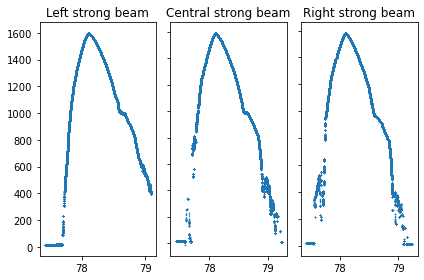

In [44]:
# I used a dataset on my personal machine to make this plot

# Plot only high confidence (i.e. likely signal) photons only
fig,axs = plt.subplots(1,3)
axs[0].plot(strong_left['lat'][strong_left['signal_conf']==4], strong_left['elev'][strong_left['signal_conf']==4], '.', markersize=0.2)
axs[0].set_title('Left strong beam')
axs[1].plot(strong_central['lat'][strong_central['signal_conf']==4], strong_central['elev'][strong_central['signal_conf']==4], '.', markersize=0.2)
axs[1].set_title('Central strong beam')
axs[2].plot(strong_right['lat'][strong_right['signal_conf']==4], strong_right['elev'][strong_right['signal_conf']==4], '.', markersize=0.2)
axs[2].set_title('Right strong beam')

for ax in axs.flat:
    ax.label_outer()
plt.tight_layout()
plt.show()